In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
!pip install pyngrok
!pip install flask_cors
# !pip install pandas
# !pip install PyYAML

In [30]:
import cv2
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader

In [20]:
def get_labels():
  # load YAML
  with open('/content/drive/MyDrive/yolo_training/yolov7/data.yaml',mode='r') as f:
      data_yaml = yaml.load(f,Loader=SafeLoader)

  labels = data_yaml['names']
  return labels

In [22]:
from pyngrok import ngrok

port = 5000
def connect_ngrok():
  key = '2drUIclnpVTcH6RCHRrmUkb5kzv_6Ng62FfDCagbQJ656F6DL'

  ngrok.set_auth_token(key)
  url = ngrok.connect(port).public_url
  print(url)

In [23]:
_models = [
    ['Yolo v5: ', '/content/drive/MyDrive/yolo_training/yolov5/runs/train/Model9/weights/best.onnx'],
    ['Yolo v7: ', '/content/drive/MyDrive/Increase-mAp/yolov7/runs/train/Model/weights/best.onnx']
  ]

In [24]:
def load_models():
  # load YOLO model
  loaded_models = []
  for _model in _models:
    name, path = _model
    yolo = cv2.dnn.readNetFromONNX(path)
    yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
    yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
    loaded_models.append([name, yolo])
  return loaded_models

In [25]:
INPUT_WH_YOLO = 640
def load_img_predict(nparr, model):
  # load the image
  img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
  image = img.copy()
  row, col, d = image.shape

  # get the YOLO prediction from the the image
  # step-1 convert image into square image (array)
  max_rc = max(row,col)
  input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
  input_image[0:row,0:col] = image
  # step-2: get prediction from square array
  blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WH_YOLO,INPUT_WH_YOLO),swapRB=True,crop=False)
  model.setInput(blob)
  preds = model.forward() # detection or prediction from YOLO
  return img, input_image, preds

In [26]:
# Non Maximum Supression
# step-1: filter detection based on confidence (0.4) and probability score (0.25)
def draw_boxes(preds, input_image):
  detections = preds[0]
  boxes = []
  confidences = []
  classes = []

  # widht and height of the image (input_image)
  image_w, image_h = input_image.shape[:2]
  x_factor = image_w/INPUT_WH_YOLO
  y_factor = image_h/INPUT_WH_YOLO

  for i in range(len(detections)):
      row = detections[i]
      confidence = row[4] # confidence of detection an object
      if confidence > 0.4:
          class_score = row[5:].max() # maximum probability from 20 objects
          class_id = row[5:].argmax() # get the index position at which max probabilty occur

          if class_score > 0.25:
              cx, cy, w, h = row[0:4]
              # construct bounding from four values
              # left, top, width and height
              left = int((cx - 0.5*w)*x_factor)
              top = int((cy - 0.5*h)*y_factor)
              width = int(w*x_factor)
              height = int(h*y_factor)

              box = np.array([left,top,width,height])

              # append values into the list
              confidences.append(confidence)
              boxes.append(box)
              classes.append(class_id)

  # clean
  boxes_np = np.array(boxes).tolist()
  confidences_np = np.array(confidences).tolist()

  # NMS
  index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45).flatten()
  return index, boxes_np, confidences_np, classes

In [27]:
# Initialize an empty list to store class labels
def labels_boxes(index, image, boxes_np, confidences_np, classes, labels):
  class_labels = []

  # Draw the Bounding Boxes
  for ind in index:
      # extract bounding box
      x, y, w, h = boxes_np[ind]
      bb_conf = int(confidences_np[ind] * 100)
      classes_id = classes[ind]
      class_name = labels[classes_id]

      # Append class label to the list
      class_labels.append(class_name)

      text = f'{class_name}: {bb_conf}%'
      if class_name=="trash" or class_name=="plastic":
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 2)
      else:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
      cv2.rectangle(image, (x, y - 30), (x + w, y), (255, 255, 255), -1)

      cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 0.7, (0, 0, 0), 1)

  # Convert the list to a set to get distinct elements
  distinct_classes = set(class_labels)

  # Create a dictionary to count occurrences of each class label\
  # Define the list of all possible labels
  all_labels = ['plastic', 'paper', 'metal', 'trash', 'glass', 'cardboard']

  # Create a dictionary with all labels initialized to 0
  class_counts = {label: 0 for label in all_labels}

  # Update counts based on the actual occurrences in the list
  for label in class_labels:
      class_counts[label] += 1

  return class_labels, distinct_classes, class_counts




In [28]:
from sklearn import svm
import numpy as np

def svm_classifier_predict(class_labels):
  # Define the labels for non-recyclable materials (trash and plastic)
  non_recyclable_labels = ['trash', 'plastic']

  # Count occurrences of each material type for each sample
  X_rows = []
  for sample in class_labels:
      X_row = [0, 0, 0, 0, 0, 0]  # Initialize counts for each material type
      for idx, material in enumerate(['plastic', 'paper', 'metal', 'trash', 'glass', 'cardboard']):
          if material == sample:
              X_row[idx] += 1
      X_rows.append(X_row)

  # Convert X_rows to a numpy array
  X = np.array(X_rows)

  # Convert non-recyclable labels to 0, all others to 1
  y = np.array([0 if label in non_recyclable_labels else 1 for label in class_labels])

  # Initialize SVM classifier
  clf = svm.SVC(kernel='linear')

  # Train the classifier
  clf.fit(X, y)
  # Now, you can use this trained classifier to predict the recyclability of new items
  X_test = np.array(X_rows)

  # Predict the recyclability of the items using the trained classifier
  predictions = clf.predict(X_test)


  # Print the predictions
  return predictions

https://616b-35-230-99-186.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [29/May/2024 17:14:57] "POST /predict HTTP/1.1" 200 -


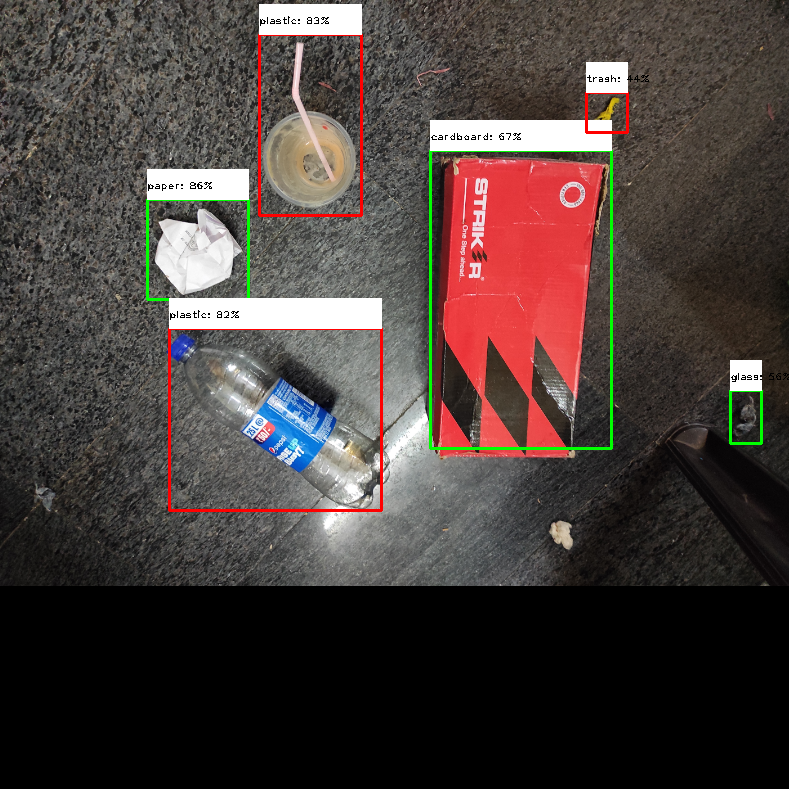

INFO:werkzeug:127.0.0.1 - - [29/May/2024 17:15:21] "POST /predict HTTP/1.1" 200 -


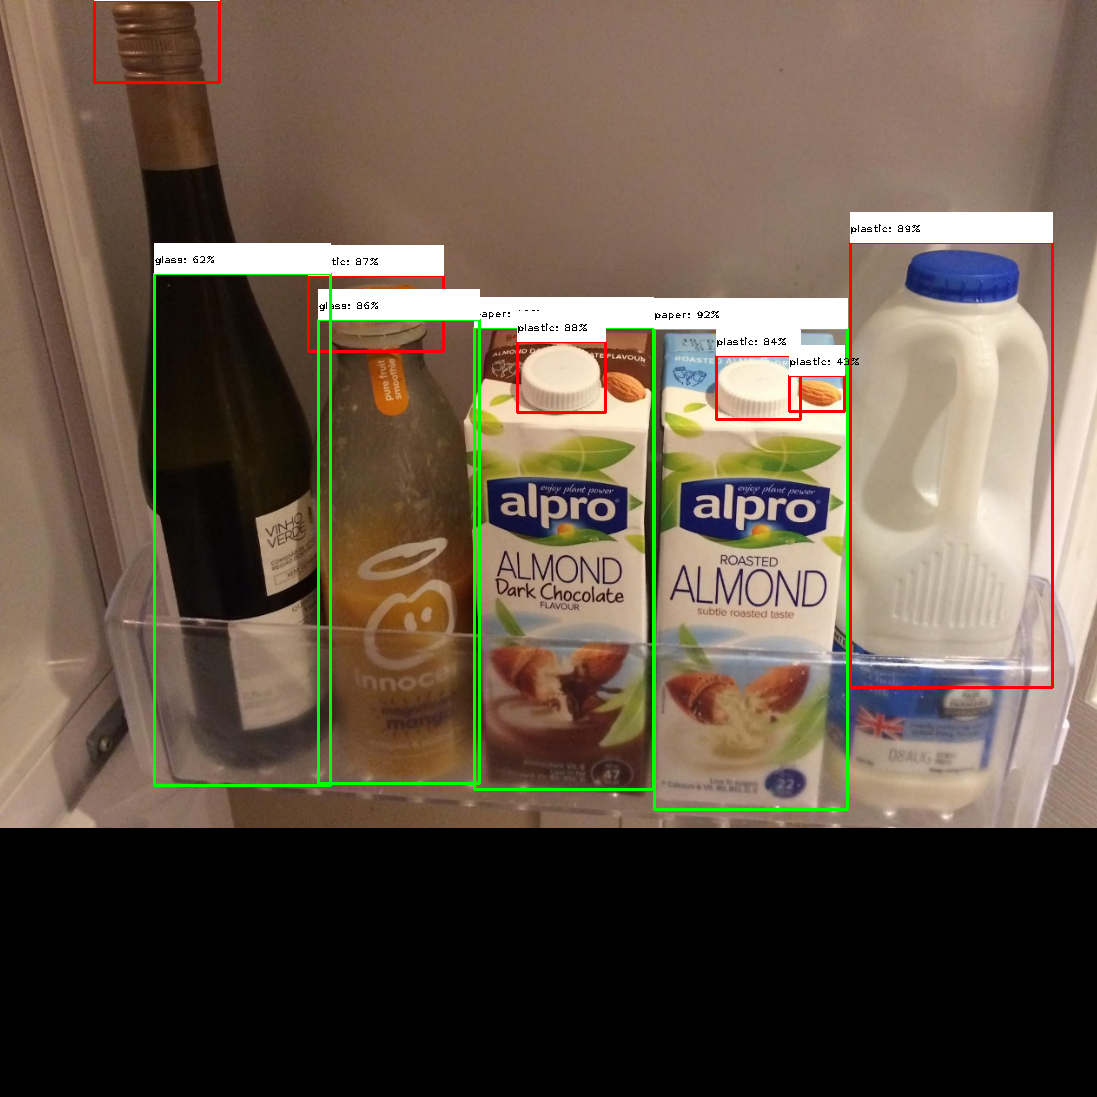

INFO:werkzeug:127.0.0.1 - - [29/May/2024 17:18:54] "POST /predict HTTP/1.1" 200 -


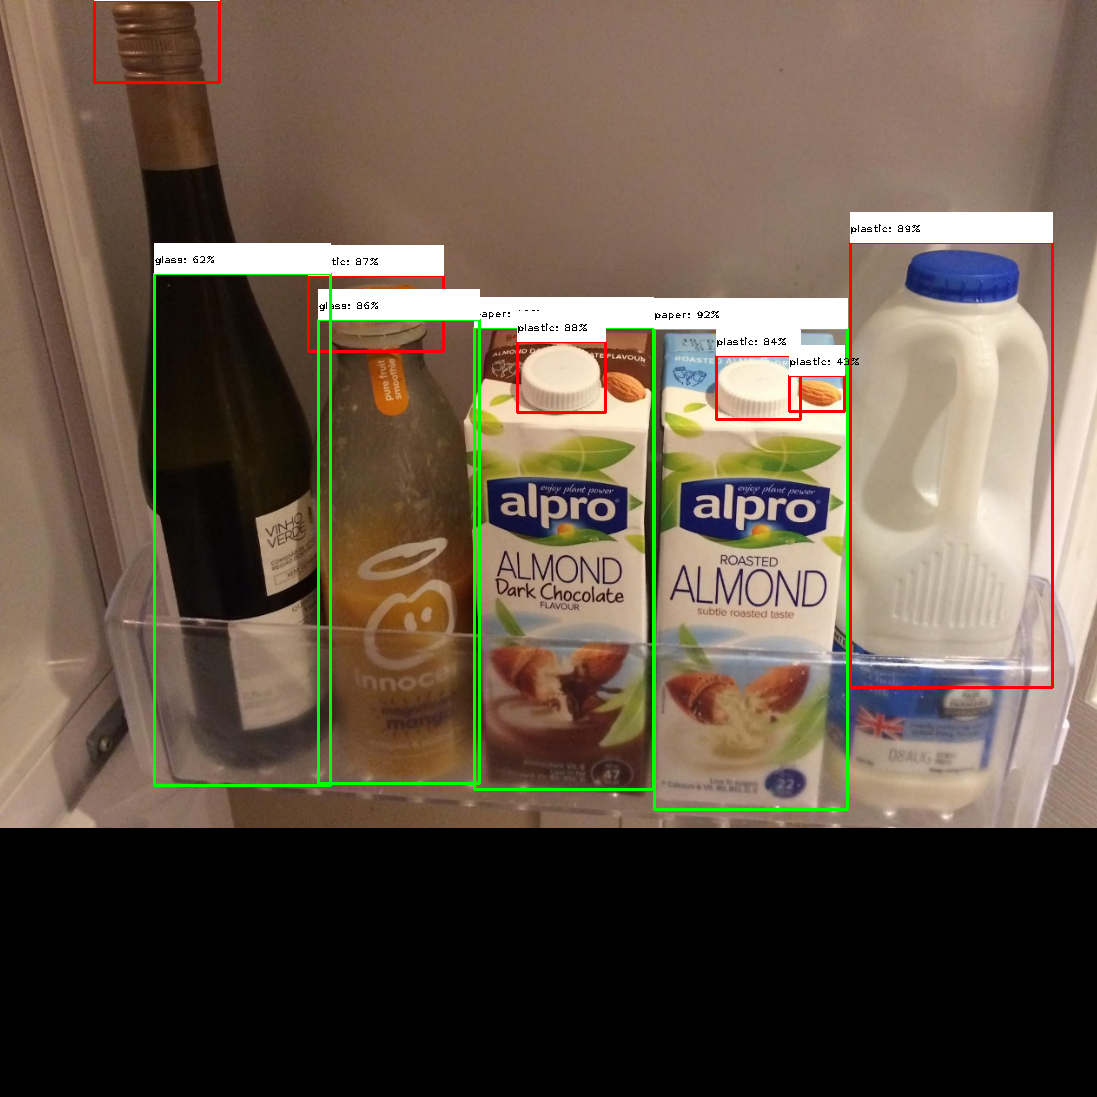

INFO:werkzeug:127.0.0.1 - - [29/May/2024 17:19:53] "POST /predict HTTP/1.1" 200 -


In [ ]:
from google.colab.patches import cv2_imshow
import cv2

from flask import Flask, request, jsonify, send_file
from flask_cors import CORS
import numpy as np
import base64
import tempfile

connect_ngrok()

app = Flask(__name__)
CORS(app)

labels = get_labels()
loaded_models = load_models()

@app.route('/')
def get():
    return 'Flask server is running!'

# Define an endpoint for receiving image and returning prediction
@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No file part'})

    file = request.files['image']
    if file.filename == '':
        return jsonify({'error': 'No selected file'})

    try:
      predictions = []
      image_stream = file.read()

      # Convert the byte stream to a numpy array
      nparr = np.frombuffer(image_stream, np.uint8)

      class_labels = get_labels()

      for _model in loaded_models:
        name, loaded_model = _model
        img, image, preds = load_img_predict(nparr, loaded_model)
        index, boxes_np, confidences_np, classes = draw_boxes(preds, image)
        # print(image.shape)
        class_labels, distinct_classes, class_counts = labels_boxes(index, image, boxes_np, confidences_np, classes, labels)
        predictions = svm_classifier_predict(class_labels)

        cv2_imshow(image)

        _, buffer = cv2.imencode('.jpg', image)
        img_str = base64.b64encode(buffer).decode('utf-8')

        response = {
            'predictions': predictions.tolist(),
            'image_base64': img_str,
            'classes': class_counts
        }
        return jsonify(response)
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(port=port)  # Run the Flask app
